# MIP Control

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [46]:
from ctrl.system.tf import PID
from ctrl.block.linear import SISO, Gain, Feedback
from ctrl.block.logger import Logger

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [4]:
from ctrl.client import Controller
#HOST, PORT = "localhost", 9999
HOST, PORT = "192.168.10.101", 9999
mip = Controller(host = HOST, port = PORT)

## Probe the controller

In [5]:
print(mip.info('all'))

> Controller with 6 device(s), 7 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. encoder1
  3. encoder2
  4. imu
  5. is_running
  6. motor1
  7. motor2
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. encoder2[enabled] >> encoder2
  4. imu[enabled] >> imu
> filters
> sinks
  1. motor1 >> motor1[enabled]
  2. motor2 >> motor2[enabled]



## Attach a logger

In [6]:
mip.add_sink('logger', Logger(), ['clock', 'encoder1','encoder2','imu'])
print(mip.info('sinks'))

> sinks
  1. motor1 >> motor1[enabled]
  2. motor2 >> motor2[enabled]
  3. clock, encoder1, encoder2, imu >> logger[enabled]



## Run the motors and read the encoders

In [7]:
mip.set_source('encoder1',reset=True)
mip.set_source('encoder2',reset=True)
mip.set_sink('logger',reset=True)
with mip:
    mip.set_signal('motor1',100)
    mip.set_signal('motor2',100)
    time.sleep(2)

In [8]:
log = mip.read_sink('logger')

clock = log[:,0]
encoder1 = log[:,1]
encoder2 = log[:,2]
imu = log[:,3]

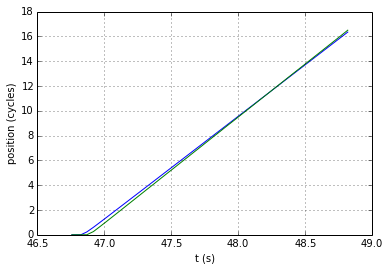

In [9]:
plt.plot(clock, encoder1, \
         clock,encoder2)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

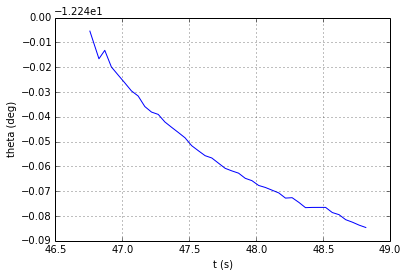

In [10]:
plt.plot(clock, 180*imu/math.pi)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('theta (deg)')
plt.grid()

## Position Control

In [11]:
mip.add_signal('reference1')

In [12]:
mip.add_sink('logger', Logger(), ['clock', 'encoder1','reference1','motor1'])
print(mip.info('sinks'))

> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, encoder1, reference1, motor1 >> logger[enabled]



In [13]:
Kp = 100
mip.add_filter('controller', 
               Feedback(block = Gain(gain = Kp)),
               ['encoder1', 'reference1'], 
               ['motor1'])

In [14]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 3 sink(s), and 1 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. encoder1
  3. encoder2
  4. imu
  5. is_running
  6. motor1
  7. motor2
  8. reference1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. encoder2[enabled] >> encoder2
  4. imu[disabled] >> imu
> filters
  1. encoder1, reference1 >> controller[enabled] >> motor1
> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, encoder1, reference1, motor1 >> logger[enabled]



In [15]:
mip.set_source('encoder1',reset=True)
mip.set_sink('logger',reset=True)
with mip:
    mip.set_signal('motor2',0)
    mip.set_signal('reference1',1)
    time.sleep(2)

In [16]:
log = mip.read_sink('logger')

clock = log[:,0]
encoder1 = log[:,1]
reference1 = log[:,2]
motor1 = log[:,3]

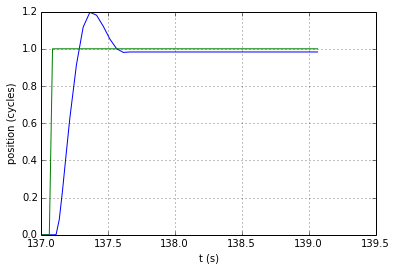

In [17]:
plt.plot(clock, encoder1, \
         clock, reference1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

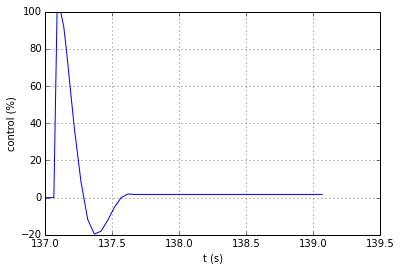

In [18]:
plt.plot(clock, motor1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

# Proportional Angle Control

In [20]:
mip.remove_filter('controller')

ValueError: list.remove(x): x not in list

In [21]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 3 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. encoder1
  3. encoder2
  4. imu
  5. is_running
  6. motor1
  7. motor2
  8. reference1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. encoder2[enabled] >> encoder2
  4. imu[disabled] >> imu
> filters
> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, encoder1, reference1, motor1 >> logger[enabled]



In [22]:
mip.add_sink('logger', Logger(), ['clock', 'imu','reference1','motor1'])
print(mip.info('sinks'))

> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, imu, reference1, motor1 >> logger[enabled]



In [53]:
Kp = -200
Kd = -10
period = 0.01
mip.add_filter('controller', 
               Feedback(block = SISO(model = PID(Kp = Kp, Kd = Kd, period = period))),
               ['imu', 'reference1'], 
               ['motor1'])

In [48]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 3 sink(s), and 1 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. encoder1
  3. encoder2
  4. imu
  5. is_running
  6. motor1
  7. motor2
  8. reference1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. encoder2[enabled] >> encoder2
  4. imu[disabled] >> imu
> filters
  1. imu, reference1 >> controller[enabled] >> motor1
> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, imu, reference1, motor1 >> logger[enabled]



In [55]:
mip.set_sink('logger',reset=True)
with mip:
    mip.set_signal('reference1',0)
    time.sleep(20)

In [34]:
log = mip.read_sink('logger')

clock = log[:,0]
imu = log[:,1]
reference1 = log[:,2]
motor1 = log[:,3]

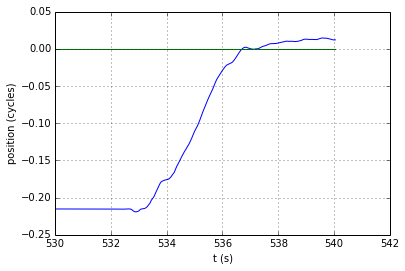

In [35]:
plt.plot(clock, imu, \
         clock, reference1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

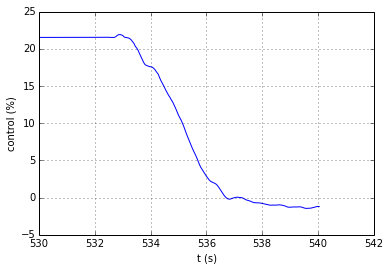

In [36]:
plt.plot(clock, motor1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()